# Event data

## Importing libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch, Sbopen, VerticalPitch
import pandas as pd

## Plotting shots

### From both teams

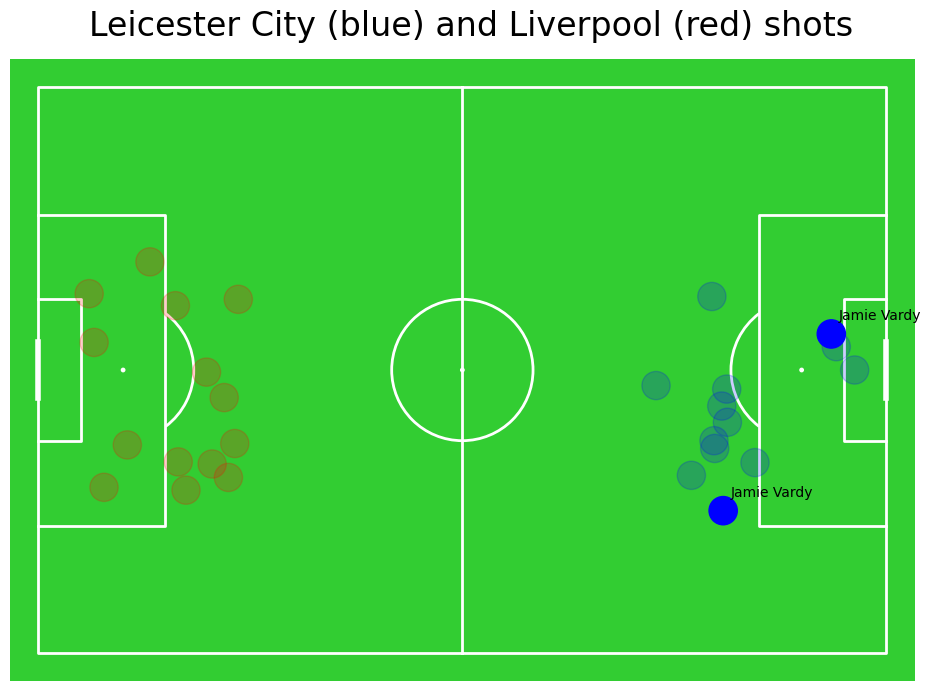

In [2]:
# Defining parser
parser = Sbopen()

# Getting Leicester City - Liverpool 2015/2016
df, related, freeze, tactics = parser.event(3754275)

# Getting team names
home_team, away_team = df.team_name.unique()

# Getting shots
shots = df.loc[df['type_name'] == 'Shot'].set_index('id')

# Using mplsoccer Pitch class
pitch = Pitch(pitch_color='limegreen', line_color = "white")
fig, ax = pitch.draw(figsize=(10, 7))
pitch_length = 120
pitch_width = 80

# Plotting shots
for i,shot in shots.iterrows():
    
    # Getting information about the shot
    x = shot['x']
    y = shot['y']
    goal = shot['outcome_name']=='Goal'
    team_name = shot['team_name']    
    
    # Setting circle size
    circleSize=2
    
    # Leicester City
    if (team_name == home_team):
        if goal:
            shotCircle = plt.Circle((x,y), circleSize, color="blue")
            plt.text(x+1,y-2,shot['player_name']) 
        else:
            shotCircle = plt.Circle((x,y), circleSize, color="blue")     
            shotCircle.set_alpha(.2)
            
    # Liverpool
    else:
        if goal:
            shotCircle = plt.Circle((pitch_length - x, pitch_width - y), circleSize, color="red") 
            plt.text(pitch_length - x + 1, pitch_width - y - 2 ,shot['player_name'])
        else:
            shotCircle = plt.Circle((pitch_length - x, pitch_width - y), circleSize, color="red")      
            shotCircle.set_alpha(.2)
            
    # Adding shot
    ax.add_patch(shotCircle)

# Setting figure parameters
fig.suptitle("Leicester City (blue) and Liverpool (red) shots", fontsize = 24)     
fig.set_size_inches(10, 7)

plt.show()

### Leicester City's ones

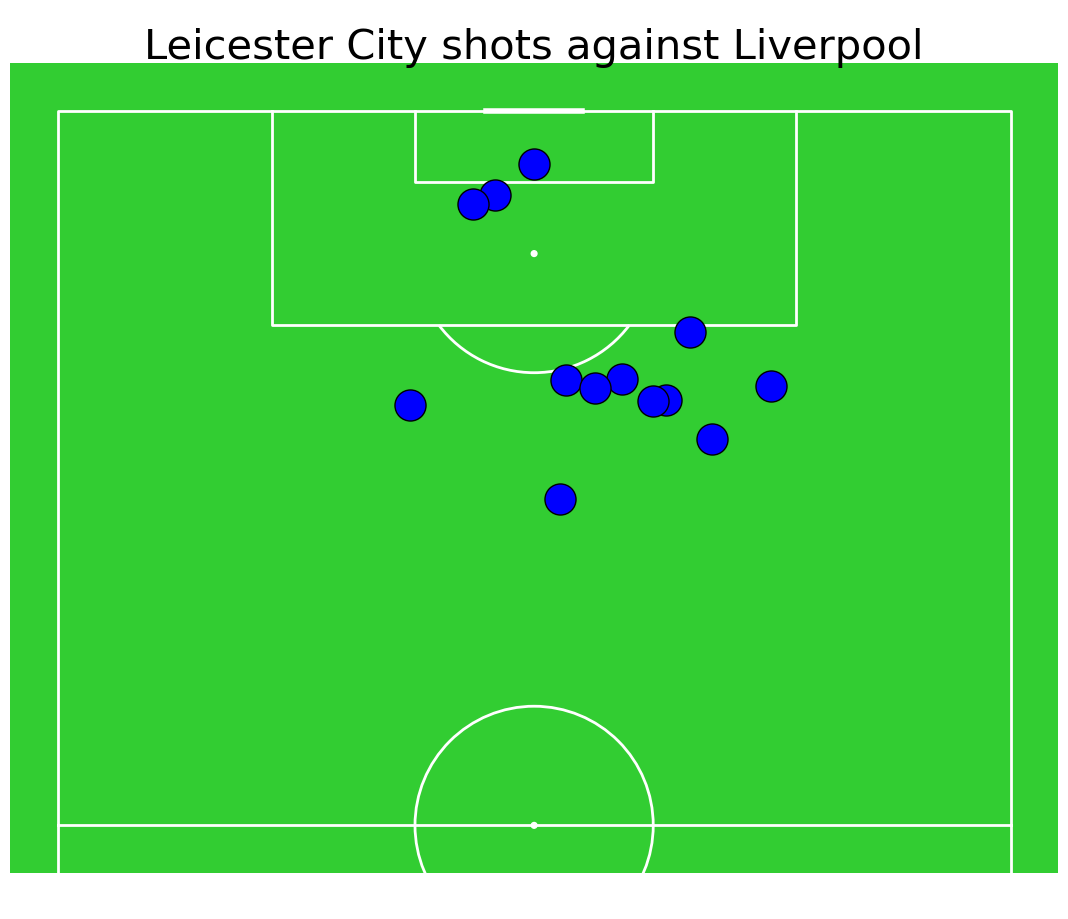

In [3]:
# Using mplsoccer Pitch class
pitch = VerticalPitch(pitch_color='limegreen', line_color='white', half = True)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# Getting Leicester City events
mask_leicester = (df.type_name == 'Shot') & (df.team_name == home_team)
df_leicester = df.loc[mask_leicester, ['x', 'y', 'outcome_name', "player_name"]]

# Plotting shots
pitch.scatter(df_leicester.x, df_leicester.y, alpha = 1, s = 500, color = "blue", ax=ax['pitch'], edgecolors="black") 
fig.suptitle("Leicester City shots against Liverpool", fontsize = 30)

plt.show()

## Plotting passes

###  From Riyad Mahrez

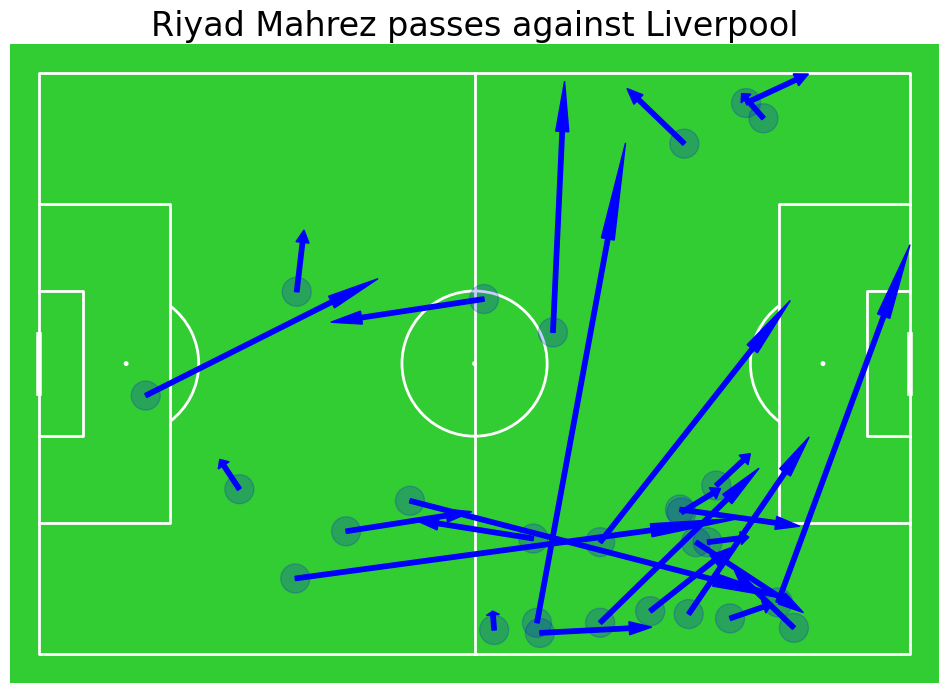

In [4]:
# Getting passes without throw-in
passes = df.loc[df['type_name'] == 'Pass'].loc[df['sub_type_name'] != 'Throw-in'].set_index('id')

# Defining the pitch
pitch = Pitch(pitch_color='limegreen', line_color='white')
fig, ax = pitch.draw(figsize=(10, 7))

for i, pass_row in passes.iterrows():
    if pass_row['player_name']=='Riyad Mahrez':
        # Getting pass coordinates
        x = pass_row['x']
        y = pass_row['y']
        
        passCircle = plt.Circle((x,y), 2, color="blue")
        passCircle.set_alpha(.2)
        ax.add_patch(passCircle)
        
        # Getting receiver coordinates
        dx = pass_row['end_x']-x
        dy = pass_row['end_y']-y
        passArrow = plt.Arrow(x,y,dx,dy,width=3,color="blue")
        ax.add_patch(passArrow)

ax.set_title("Riyad Mahrez passes against Liverpool", fontsize = 24)
fig.set_size_inches(10, 7)
plt.show()

### From each Leicester City player

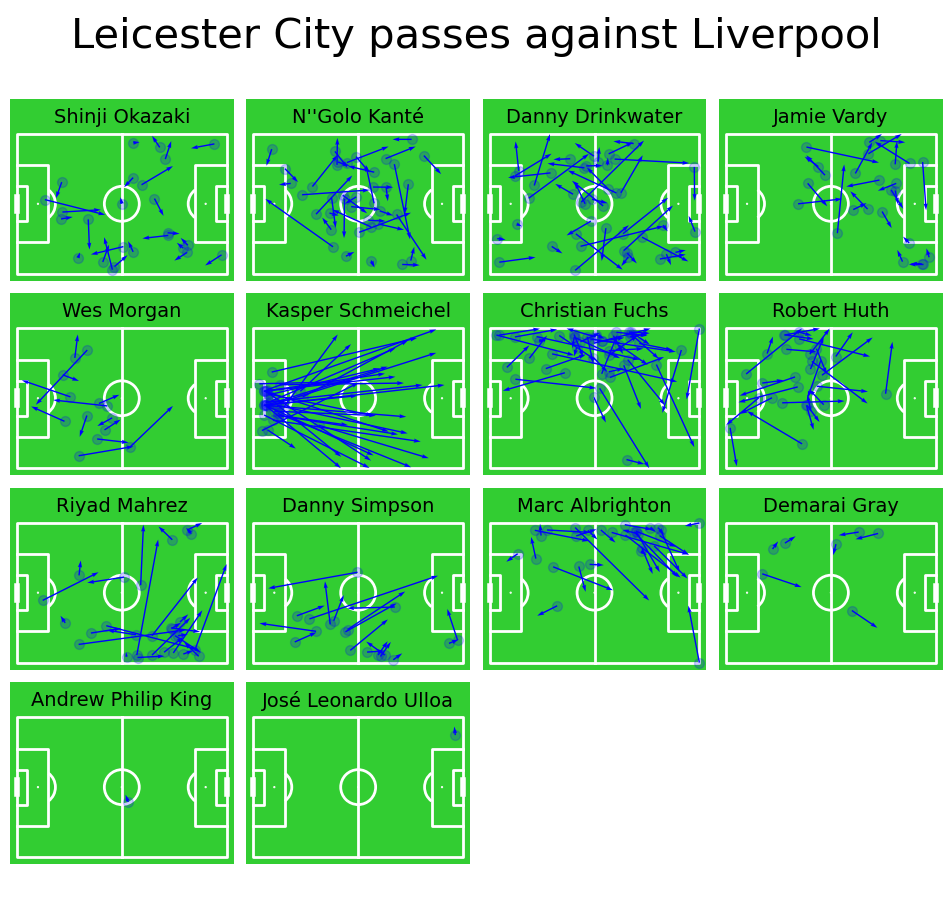

In [5]:
# Selecting Leicester City players
mask_leicester = (df.type_name == 'Pass') & (df.team_name == "Leicester City") & (df.sub_type_name != "Throw-in")
df_passes = df.loc[mask_leicester, ['x', 'y', 'end_x', 'end_y', 'player_name']]

# Getting the names of the passers
names = df_passes['player_name'].unique()

# Drawing multiple pitches
pitch = Pitch(pitch_color='limegreen', line_color='white', pad_top=20)
fig, axs = pitch.grid(ncols = 4, nrows = 4, grid_height=0.85, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0.04, endnote_space=0.01)


for name, ax in zip(names, axs['pitch'].flat[:len(names)]):
    # Putting player name over the plot
    ax.text(60, -10, name,
            ha='center', va='center', fontsize=14)
    
    # Selecting passes from the player
    player_df = df_passes.loc[df_passes["player_name"] == name]
    
    # Drawing circles
    pitch.scatter(player_df.x, player_df.y, alpha = 0.2, s = 50, color = "blue", ax=ax)
    
    # Drawing arrows
    pitch.arrows(player_df.x, player_df.y,
            player_df.end_x, player_df.end_y, color = "blue", ax=ax, width=1)

# Removing excess pitches
for ax in axs['pitch'][-1, 16 - len(names):]:
    ax.remove()

# Setting title
axs['title'].text(0.5, 0.5, 'Leicester City passes against Liverpool', ha='center', va='center', fontsize=30)
plt.show()

## Passing networks and centralisation indexes

### Passing network

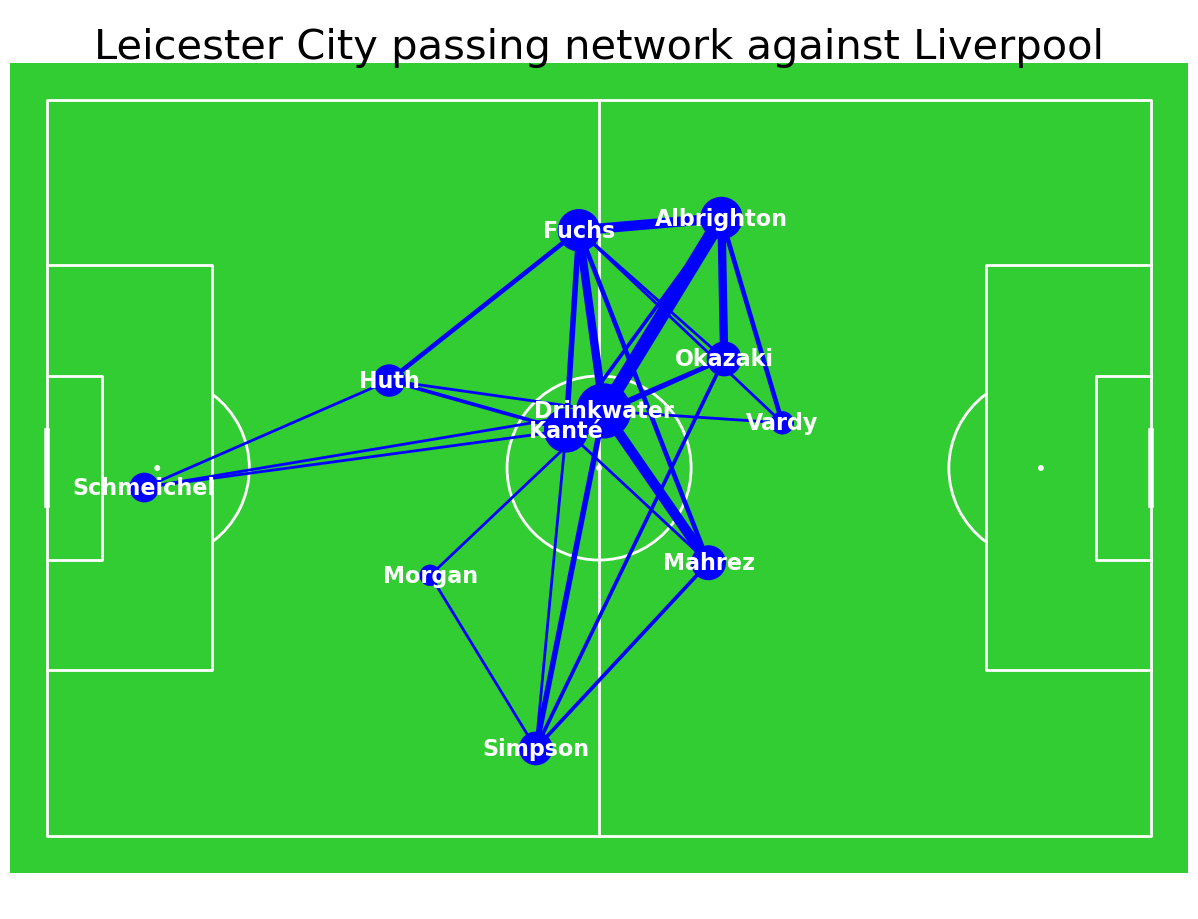

In [12]:
# Checking for index of first sub event
sub = df.loc[df["type_name"] == "Substitution"].loc[df["team_name"] == "Leicester City"].iloc[0]["index"]

# Defining the mask
mask_leicester = (df.type_name == 'Pass') & (df.team_name == "Leicester City") & (df.index < sub) & (df.outcome_name.isnull()) & (df.sub_type_name != "Throw-in")

# Selecting necessary columns
df_pass = df.loc[mask_leicester, ['x', 'y', 'end_x', 'end_y', "player_name", "pass_recipient_name"]]

# Keeping the surname to avoid very long names
df_pass["player_name"] = df_pass["player_name"].apply(lambda x: str(x).split()[-1])
df_pass["pass_recipient_name"] = df_pass["pass_recipient_name"].apply(lambda x: str(x).split()[-1])

# Creating an empty data frame 
scatter_df = pd.DataFrame()

for i, name in enumerate(df_pass["player_name"].unique()):
    # Getting coordinates
    passx = df_pass.loc[df_pass["player_name"] == name]["x"].to_numpy()
    recx = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_x"].to_numpy()
    passy = df_pass.loc[df_pass["player_name"] == name]["y"].to_numpy()
    recy = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_y"].to_numpy()
    
    # Replacing player name by surname
    scatter_df.at[i, "player_name"] = name
    
    # Making sure that x and y location for each circle representing the player is the average of passes and receptions
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))
    
    # Calculating the number of passes
    scatter_df.at[i, "no"] = df_pass.loc[df_pass["player_name"] == name].count().iloc[0]

# Adjusting the size of a circle so that the player who made more passes
scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)

# Counting passes between players
df_pass["pair_key"] = df_pass.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)
lines_df = df_pass.groupby(["pair_key"]).x.count().reset_index()
lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)

# Setting a treshold to keep frequent links
lines_df = lines_df[lines_df['pass_count'] > 2]

# Plotting pitch and vertices
pitch = Pitch(pitch_color='limegreen', line_color='white')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='blue', edgecolors='blue', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)

# Plotting player names
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x, row.y), c='white', va='center', ha='center', weight = "bold", size=16, ax=ax["pitch"], zorder = 4)


for i, row in lines_df.iterrows():
    passer = row["pair_key"].split("_")[0]
    receiver = row['pair_key'].split("_")[1]
    
    # Taking the average location of players to plot a line between them
    passer_x = scatter_df.loc[scatter_df["player_name"] == passer]['x'].iloc[0]
    passer_y = scatter_df.loc[scatter_df["player_name"] == passer]['y'].iloc[0]
    receiver_x = scatter_df.loc[scatter_df["player_name"] == receiver]['x'].iloc[0]
    receiver_y = scatter_df.loc[scatter_df["player_name"] == receiver]['y'].iloc[0]
    num_passes = row["pass_count"]
    
    # Adjusting the line width so that the more passes, the wider the line
    line_width = (num_passes / lines_df['pass_count'].max() * 10)
    
    # Plotting lines
    pitch.lines(passer_x, passer_y, receiver_x, receiver_y,
                alpha=1, lw=line_width, zorder=2, color="blue", ax = ax["pitch"])

fig.suptitle("Leicester City passing network against Liverpool", fontsize = 30)
plt.show()

### Centralisation index

In [7]:
# Calculating number of successful passes by player
no_passes = df_pass.groupby(['player_name']).x.count().reset_index()
no_passes.rename({'x':'pass_count'}, axis='columns', inplace=True)

# Finding the one who made most passes
max_no = no_passes["pass_count"].max()

# Calculating the denominator - 10 * the total sum of passes
denominator = 10 * no_passes["pass_count"].sum()

# Calculating the nominator
nominator = (max_no - no_passes["pass_count"]).sum()

# Calculating the centralisation index
centralisation_index = nominator/denominator
print("Centralisation index is ", centralisation_index)

Centralisation index is  0.04042553191489362


## Pass heatmaps

### Danger passes locations

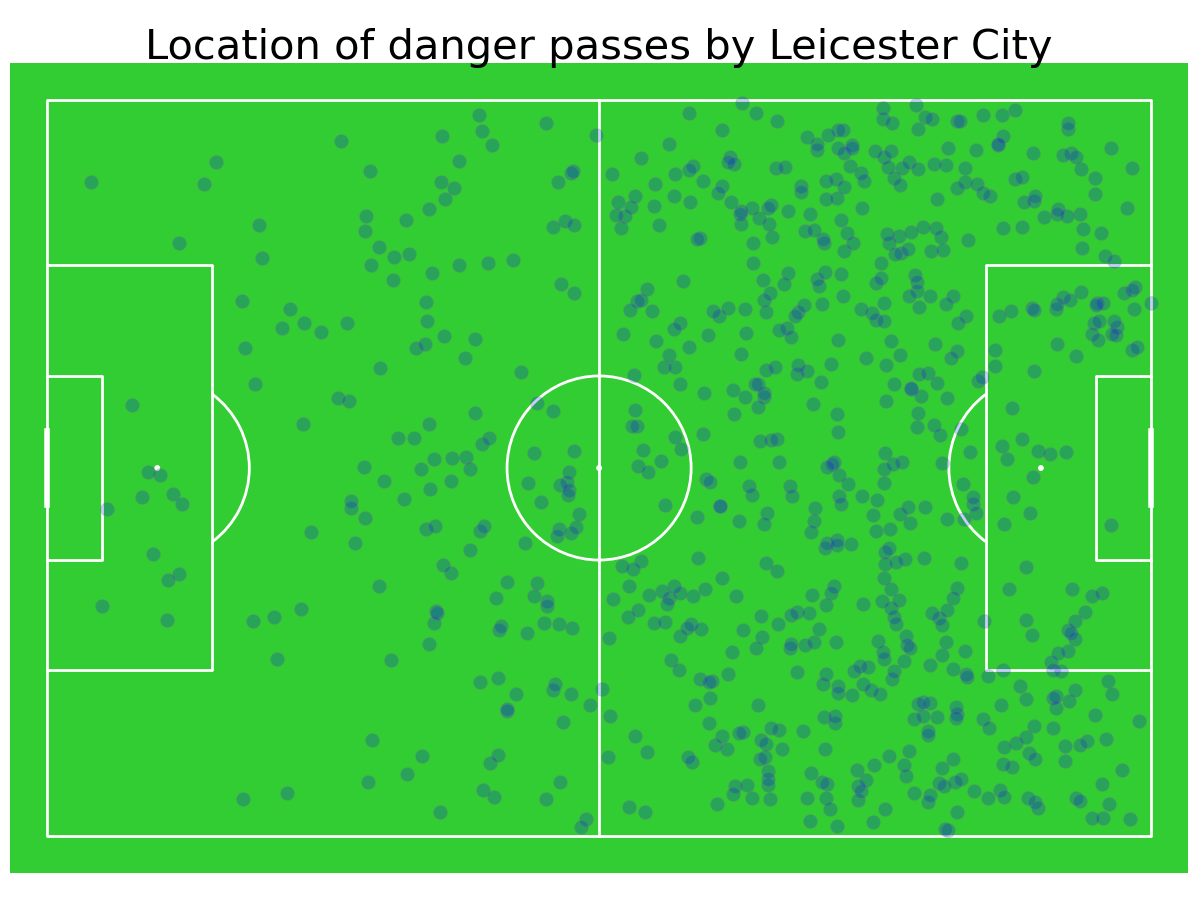

In [8]:
# Selecting 2015/2016 Premier League season
df_match = parser.match(competition_id=2, season_id=27)

# Selecting Leicester City team
team = "Leicester City"

# Getting the list of games by our team, either home or away
match_ids = df_match.loc[(df_match["home_team_name"] == team) | (df_match["away_team_name"] == team)]["match_id"].tolist()
#calculate number of games
no_games = len(match_ids)

# Building an empty data frame
danger_passes = pd.DataFrame()

# 
for idx in match_ids:
    # Opening the event data from the game
    df = parser.event(idx)[0]
    
    # Ensuring 
    for period in [1, 2]:
        # Keeping only accurate passes
        mask_pass = (df.team_name == team) & (df.type_name == "Pass") & (df.outcome_name.isnull()) & (df.period == period) & (df.sub_type_name.isnull())
        
        # Keeping only necessary columns
        passes = df.loc[mask_pass, ["x", "y", "end_x", "end_y", "minute", "second", "player_name"]]
        
        # Keeping only shots by Leicester City in this period
        mask_shot = (df.team_name == team) & (df.type_name == "Shot") & (df.period == period)
        
        # Keeping only necessary columns
        shots = df.loc[mask_shot, ["minute", "second"]]
        
        # Converting time to seconds
        shot_times = shots['minute'] * 60 + shots['second']
        
        # Finding starts of the window
        shot_window = 15
        shot_start = shot_times - shot_window
        
        # Avoiding negative shot starts
        shot_start = shot_start.apply(lambda i: i if i>0 else (period-1)*45)
        
        # Converting to seconds
        pass_times = passes['minute'] * 60 + passes['second']
        
        # Checking if pass is in any of the windows for this half
        pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())

        # Keeping only danger passes
        danger_passes_period = passes.loc[pass_to_shot]
        
        # Concatenating dataframe with a previous one to keep danger passes from the whole competition
        danger_passes = pd.concat([danger_passes, danger_passes_period], ignore_index = True)
        
# Plotting pitch
pitch = Pitch(pitch_color='limegreen', line_color='white')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# Scattering the location on the pitch
pitch.scatter(danger_passes.x, danger_passes.y, s=100, color='blue', edgecolors='grey', linewidth=1, alpha=0.2, ax=ax["pitch"])

# Plotting arrows
# pitch.arrows(danger_passes.x, danger_passes.y, danger_passes.end_x, danger_passes.end_y, color = "blue", ax=ax['pitch'])
# --> There are too many passes in a season to plot arrows

# Adding title
fig.suptitle('Location of danger passes by ' + team, fontsize = 30)
plt.show()

### Danger pass zones per game

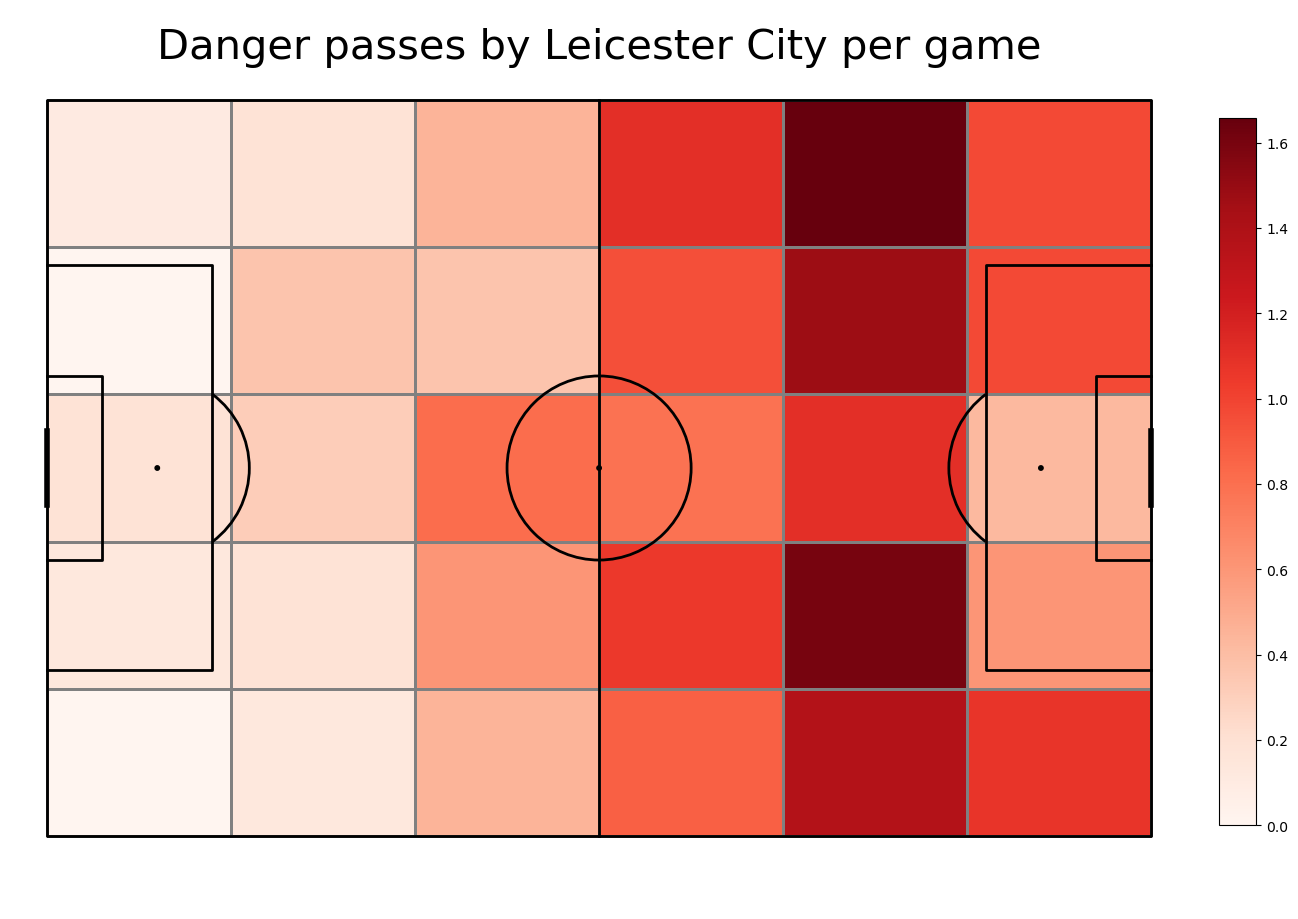

In [9]:
# Plotting pitch
pitch = Pitch(line_zorder=2, pitch_color='white', line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# Getting the 2D histogram
bin_statistic = pitch.bin_statistic(danger_passes.x, danger_passes.y, statistic='count', bins=(6, 5), normalize=False)

# Normalizing by number of games
bin_statistic["statistic"] = bin_statistic["statistic"]/no_games

# Making a heatmap
pcm  = pitch.heatmap(bin_statistic, cmap='Reds', edgecolor='grey', ax=ax['pitch'])

# Legending the plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Danger passes by ' + team + " per game", fontsize = 30)
plt.show()

### Danger passes per game per player

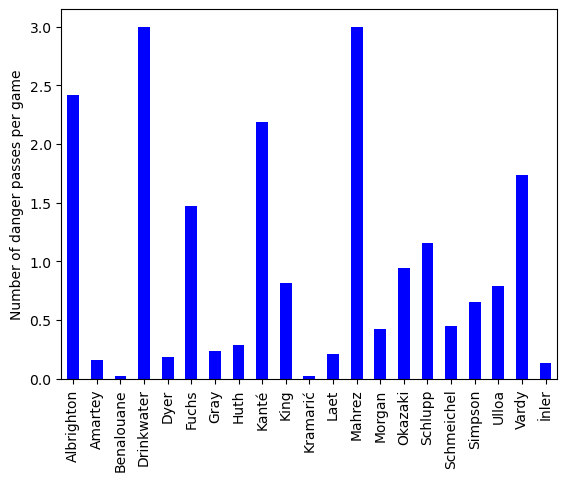

In [10]:
# Keeping surnames
danger_passes["player_name"] = danger_passes["player_name"].apply(lambda x: str(x).split()[-1])

# Counting danger passes by player and normalize them
pass_count = danger_passes.groupby(["player_name"]).x.count()/no_games

# Making a histogram
ax = pass_count.plot.bar(pass_count, color="blue")

# Making legend
ax.set_xlabel("")
ax.set_ylabel("Number of danger passes per game")

plt.show()